<a href="https://colab.research.google.com/github/amura/xray-machinelearning/blob/resnet50/resnet50_ct_scans_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 10 14:34:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import required dependencies
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data setup

In [4]:
# setup drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
# install utility for converting to dicom
!pip install simpleitk  > /dev/null 2>&1

# RESNET50

In [6]:
# Load the csv back in to a dataframe

data = pd.read_csv('/content/gdrive/MyDrive/dicom/ctscans.csv')
# convert label from string to int
mapping = {'non-covid': '0', 'covid': '1'}
data = data.replace({'label': mapping})
data.head()

,Unnamed: 0,paths,label
0,0,/content/gdrive/MyDrive/dicom/covid/c_0.dcm,1
1,1,/content/gdrive/MyDrive/dicom/covid/c_1.dcm,1
2,2,/content/gdrive/MyDrive/dicom/covid/c_2.dcm,1
3,3,/content/gdrive/MyDrive/dicom/covid/c_3.dcm,1
4,4,/content/gdrive/MyDrive/dicom/covid/c_4.dcm,1


In [7]:
from sklearn.model_selection import train_test_split
# split data 20% test

train_set, test_set = train_test_split(data, test_size=0.2)

In [8]:
# Data augmentation
# use image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                                rotation_range = 40, width_shift_range = 0.2, 
                                                                height_shift_range = 0.2, shear_range = 0.2, 
                                                                zoom_range = 0.2, horizontal_flip = True,  validation_split = 0.2)

validation_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                              validation_split = 0.2)

test_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

In [9]:
# install pydicom
!pip install pydicom

     |████████████████████████████████| 1.9MB 4.1MB/s 


In [10]:
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
import pydicom

#DICOM image reader
# https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(224, 224), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

        return image_array

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224
class_mode = 'binary'
colour_mode = 'rgb'
seed = 1234
num_epochs = 100

train_consts = {
    'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'training'
}

valid_consts = {
   'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width), 
    'shuffle': False
}

train_generator = DCMDataFrameIterator(dataframe=train_set,
                             x_col='paths',
                             y_col='label',                      
                             image_data_generator=train_datagen,
                             **train_consts)

validation_generator = DCMDataFrameIterator(dataframe=train_set,
                            x_col='paths',
                             y_col='label',                            
                             image_data_generator=validation_datagen,
                             **valid_consts)



Found 477 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


### Build up the layers

In [12]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from keras.initializers import glorot_uniform

In [13]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X_shortcut, X]) 
    X = layers.Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [14]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [15]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = layers.Input(input_shape)

    # Zero-Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    ### END CODE HERE ###

    # output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [16]:
model = ResNet50(input_shape = (224, 224, 3), classes = 2)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [17]:
from keras import callbacks
import time
# utility class for accumulating the training time
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import optimizers 

#create folder for storing results
if not os.path.exists('/content/gdrive/MyDrive/c19'): 
    print("Creating model folder") 
    os.makedirs('/content/gdrive/MyDrive/c19')

checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/c19/resnet50.hdf5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

time_callback = TimeHistory()


callbacks = [checkpoint, reduce_lr, time_callback]

 
print("number trainable weights", len(model.trainable_weights))
#compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=['acc'])

number trainable weights 214


In [19]:
%%time 
history = model.fit(
	x=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=num_epochs,
  verbose=2,
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
  callbacks=callbacks
)
print("Timing summary", time_callback.times)


Epoch 1/100
15/15 - 232s - loss: 1.0973 - acc: 0.4864 - val_loss: 3.7845 - val_acc: 0.4958

Epoch 00001: val_acc improved from -inf to 0.49580, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
15/15 - 6s - loss: 0.9840 - acc: 0.5031 - val_loss: 1.3435 - val_acc: 0.4958

Epoch 00002: val_acc did not improve from 0.49580
Epoch 3/100
15/15 - 6s - loss: 0.8918 - acc: 0.5094 - val_loss: 0.7161 - val_acc: 0.5210

Epoch 00003: val_acc improved from 0.49580 to 0.52101, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 4/100
15/15 - 6s - loss: 0.8462 - acc: 0.5702 - val_loss: 0.6861 - val_acc: 0.5294

Epoch 00004: val_acc improved from 0.52101 to 0.52941, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 5/100
15/15 - 6s - loss: 0.8962 - acc: 0.5304 - val_loss: 0.6661 - val_acc: 0.6050

Epoch 00005: val_acc improved from 0.52941 to 0.60504, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 6/100
15/15 - 6s - loss: 0.8590 - acc: 0.5157 - val_loss: 0.6794 - val_acc: 0.5378

Epoch 00006: val_acc did not improve from 0.60504
Epoch 7/100
15/15 - 6s - loss: 0.8479 - acc: 0.5493 - val_loss: 0.7085 - val_acc: 0.5042

Epoch 00007: val_acc 

### Training results

keys {'loss': [1.0973148345947266, 0.9840115308761597, 0.8917717933654785, 0.8461510539054871, 0.8962246775627136, 0.8590061664581299, 0.8479492664337158, 0.8565142154693604, 0.8477801084518433, 0.7806766033172607, 0.9794420003890991, 0.8462855219841003, 0.8578351736068726, 0.8858039975166321, 0.7570451498031616, 0.8041614890098572, 0.7612981796264648, 0.7646206021308899, 0.7476412057876587, 0.8087054491043091, 0.7992376089096069, 0.7382644414901733, 0.7207043766975403, 0.7656299471855164, 0.7204221487045288, 0.7357156872749329, 0.7142890691757202, 0.758437991142273, 0.7963568568229675, 0.7780981063842773, 0.7390155792236328, 0.7861937880516052, 0.7262511253356934, 0.7138333320617676, 0.7679516077041626, 0.7687220573425293, 0.7942266464233398, 0.7201171517372131, 0.7420408725738525, 0.7602599859237671, 0.7623109221458435, 0.7166652083396912, 0.7340484261512756, 0.763140082359314, 0.7216240167617798, 0.6936148405075073, 0.7605658769607544, 0.725189745426178, 0.7323601841926575, 0.700258

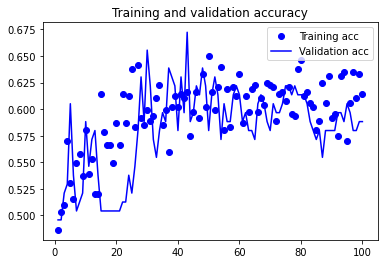

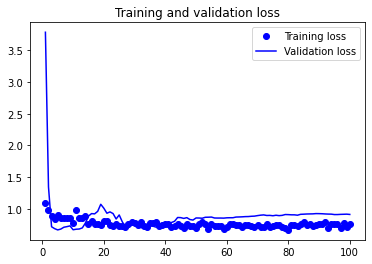

In [20]:
acc = history.history['acc']
print("keys", history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# Using the testing generator to evaluate the model after training

test_generator = DCMDataFrameIterator(dataframe=test_set,
                             x_col='paths',
                             y_col='label',   
                             image_data_generator=test_datagen,
                             **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))


Found 150 validated image filenames belonging to 2 classes.
150/150 [==============================] - 80s 536ms/step - loss: 0.8524 - acc: 0.5800


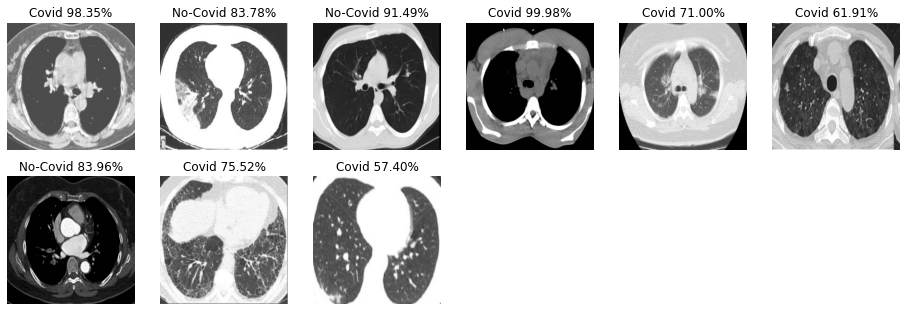

In [22]:
# show random results
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for i in range(9):
    x, y = test_generator.next()
    prediction = model.predict(np.expand_dims(x[0], axis=0))[0]
    
    plt.subplot(3, 6, i+1)
    if prediction[0] > prediction[1]:
        plt.title('Covid %.2f%%' % (prediction[0]*100))
    else:
        plt.title('No-Covid %.2f%%' % (prediction[1]*100))
    
    plt.axis('off')
    plt.imshow(x[0])
# x, y = test_generator.next()

 